TODOs: 
- [ ] 把SMACrossover策略補完(參考backtest1.py的寫法)
- [ ] 封裝好 ccxt取data的部分 
- [ ] 研究一下sizer的設定方式, 下注方式要改成可以按照比例投注

In [7]:
import backtrader as bt
import pandas as pd

import ccxt
import datetime

import matplotlib.pyplot as plt


In [62]:
class SMACrossover(bt.Strategy):
    params = (
        ('fast_sma_period', 10),
        ('slow_sma_period', 30),
        ('printlog', True),
    )

    def log(self, txt, dt=None, doprint=False):
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print(f'{dt.isoformat()}, {txt}')

    def __init__(self):
        self.fast_sma = bt.indicators.SimpleMovingAverage(
            self.data.close, period=self.params.fast_sma_period
        )
        self.slow_sma = bt.indicators.SimpleMovingAverage(
            self.data.close, period=self.params.slow_sma_period
        )
        self.crossover = bt.indicators.CrossOver(self.fast_sma, self.slow_sma)

    def next(self):
        if not self.position:
            if self.crossover > 0:
                self.order = self.buy()
                self.log('BUY CREATE, %.2f' % self.data.close[0])
        elif self.crossover < 0:
            self.order = self.sell()
            self.log('SELL CREATE, %.2f' % self.data.close[0])

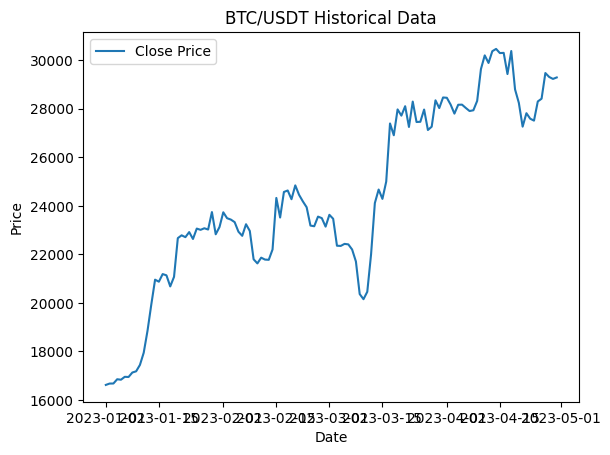

In [53]:

# Configure CCXT
exchange = ccxt.binance()
symbol = 'BTC/USDT'
timeframe = '1d'  # Use '1h' for hourly data, '1m' for minute data, etc.
since = exchange.parse8601('2023-01-01T00:00:00Z')

# Fetch historical data using CCXT
ohlcv_data = exchange.fetch_ohlcv(symbol, timeframe, since)

# Convert the data to a Pandas DataFrame
df = pd.DataFrame(ohlcv_data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['Date'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('Date', inplace=True)
df.drop(columns=['timestamp'], inplace=True)

# Create a Backtrader data feed
data = bt.feeds.PandasData(dataname=df)



# Plot the price chart
fig, ax = plt.subplots()
ax.plot(df.index, df['close'], label='Close Price')

# Set plot labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('BTC/USDT Historical Data')

# Show legend and plot
ax.legend()
plt.show()

In [67]:
def run_backtest(strategy, fast_sma_period, slow_sma_period, cash, plot=True):
    cerebro = bt.Cerebro()
    cerebro.addstrategy(strategy, fast_sma_period=fast_sma_period, slow_sma_period=slow_sma_period)
    cerebro.adddata(data)
    cerebro.broker.setcash(cash)
    cerebro.addsizer(bt.sizers.all, stake=1)
    cerebro.broker.setcommission(commission=0.001)

    
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.run()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    if plot:
        cerebro.plot(style='candlestick',iplot=False)
        #cerebro.plot()

Starting Portfolio Value: 100000000.00
2023-02-19, BUY CREATE, 24271.76
2023-03-05, SELL CREATE, 22430.24
2023-03-18, BUY CREATE, 26907.49
2023-04-25, SELL CREATE, 28300.79
Final Portfolio Value: 99999449.13


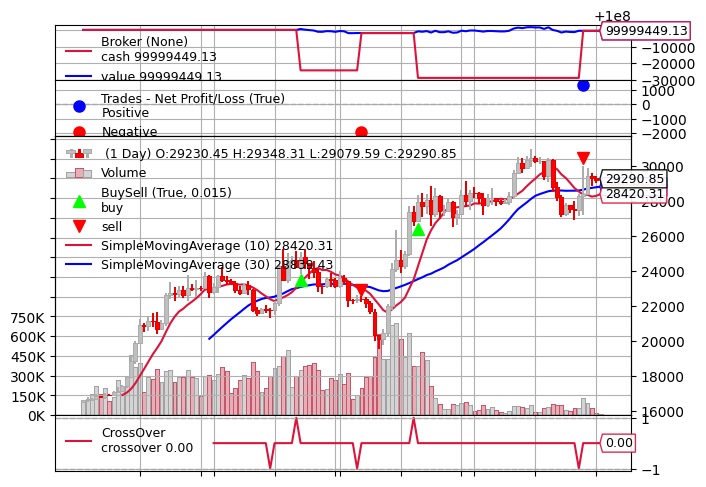

In [68]:
%matplotlib inline

fast_sma_period = 10
slow_sma_period = 30
initial_cash = 100000000

run_backtest(
    SMACrossover,
    fast_sma_period=fast_sma_period,
    slow_sma_period=slow_sma_period,
    cash=initial_cash,
    plot=True
)